In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mplPath
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline
import sys
import os
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from tqdm import tqdm

In [21]:
# Define The Training Patch generation functions

def GetNormals(nodesB, alpha):
    # Calculates the n
    nodesB_expand = np.concatenate([nodesB[-1:],nodesB,nodesB[0:1]],0)
    alpha_expand = np.concatenate([[alpha[-1]-1],alpha,[1]],0).reshape(-1,1)
    dalpha = alpha_expand[2:]-alpha_expand[1:-1]
    dalpha1 = alpha_expand[1:-1]-alpha_expand[0:-2]
    c = dalpha1/dalpha
    dNodesdAlpha = c/((c+1)*dalpha) * nodesB_expand[2:] + (1-c)/(c*dalpha) * nodesB_expand[1:-1] - 1/(c*(c+1)*dalpha) * nodesB_expand[0:-2]
    normal = np.stack([dNodesdAlpha[:,1],-dNodesdAlpha[:,0]],axis=1)/np.sqrt((dNodesdAlpha**2).sum(1)).reshape(-1,1)
    return normal

class InterpWithingBoundary():
    # Interpolation object based on scipy.interpolate.CloughTocher2DInterpolator where the boundary is explicitly definde and all points outside output np.nan
    def __init__(self, nodes, u, nodesB):
        self.nodes = nodes
        self.u = u
        self.nDims = u.shape[-1]
        self.nodesB = nodesB
        self.interp = CloughTocher2DInterpolator(nodes,u)
        self.polyPath = mplPath.Path(nodesB)

    def __call__(self, points):
        mask = self.polyPath.contains_points(points.reshape(-1,2)).reshape(points.shape[:-1])
        u_points = self.interp(points)
        u_points[~mask,:] = np.nan
        return u_points

def GetDataset(filePath):
    # Loads in and pre-processes the dataset given its file path
    # pre-processing - calculates the cubic interpolation function from the physical variable (u) and boundary normals, converts lists to numpy arrays
    data = json.load(open(filePath))
    for i in range(len(data)):
        for key in data[i].keys():
            data[i][key] = np.array(data[i][key])
        nodes = data[i]['nodes']
        boundaryNodes = data[i]['boundaryNodes']
        nodesB = nodes[boundaryNodes]
        u = data[i]['l']
        interp = InterpWithingBoundary(nodes,u,nodesB)
        data[i]['interp'] = interp
        data[i]['interpD'] = interp # Interpolation funtion for the variables that decoder is supposed to reconstruct (can be different than encoder input)

        alpha = data[i]['alpha']
        interpB = CubicSpline(np.concatenate([alpha-1,alpha,alpha+1]),np.tile(u[boundaryNodes],(3,1)))
        data[i]['interpB'] = interpB

        normal = GetNormals(nodesB, alpha)
        data[i]['normal'] = normal
        interpNormal = CubicSpline(np.concatenate([alpha-1,alpha,alpha+1]), np.tile(normal,(3,1)))
        data[i]['interpNormal'] = interpNormal

        interpNodesB = CubicSpline(np.concatenate([alpha,[1]],0), np.concatenate([nodesB,nodesB[0:1]],0), axis=0)
        data[i]['interpNodesB'] = interpNodesB

        dsdalpha = np.sqrt(((nodesB[1:] - nodesB[:-1])**2).sum(1))/(alpha[1:] - alpha[:-1])
        data[i]['dsdalpha'] = dsdalpha.mean()

    return data

def GetAreaTriang(nodes_els):
    # Calculate the area of a triangles in a mesh
    #   nodes_els - [N,3,2] tensor which containes the x,y positions of nodes of N triangles
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def GenerateTriangTrainMeshInter():
    # Generates random variation of a mesh made out of 6 triangular elements in a hexagon configuration
    # The mesh is normalized so that the longest edge length is 1
    #   nodes - [7,2] tensor which containes the x,y positions of nodes of the mesh
    #   elements - [6,3] tensor which containes the indices of the nodes of the mesh

    # constructu a hexagon with a point in the middle
    alphas = np.linspace(0,2*np.pi,7)[:-1]-2*np.pi/3 + np.random.uniform(-np.pi/15,np.pi/15,6)
    r = np.random.uniform(0.7,1,6)
    bNodes = np.stack([np.cos(alphas)*r,np.sin(alphas)*r],axis=1)
    nodes = np.concatenate([[[0,0]],bNodes],axis=0)

    # construct element matrix
    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1

    # randomly rotate the mesh
    rot = np.random.uniform(0,np.pi/3)
    rot_mat = np.array([[np.cos(rot),np.sin(rot)],[-np.sin(rot),np.cos(rot)]])
    nodes = (rot_mat@nodes.T).T
    return nodes,elements

def GetShortestDist(p,b1,b2):
    # Get the normal distance between 2D point p and a line defined by points b1 and b2
    v = b2-b1
    a = -v[1]
    b = v[0]
    c = v[1]*b1[0]-v[0]*b1[1]
    shortestDist = np.abs(a*p[0]+b*p[1]+c)/np.sqrt(a**2+b**2)
    return shortestDist

def GetShortestDistPolygon(point,nodesB):
    # Calculate the shortest distant from a 2D point to a polygon defined by array of nodes: nodesB
    n = nodesB.shape[0]
    distances = ((point-nodesB)**2).sum(1)
    idx_closeBN = np.argmin(distances)
    idx_closeBN2 = (idx_closeBN - 1 + 2*np.argmin([distances[idx_closeBN-1], distances[(idx_closeBN+1)%n]]))%n
    shortestDist = GetShortestDist(point[0], nodesB[idx_closeBN], nodesB[idx_closeBN2])
    return shortestDist

def RandomTriangSample(nodes):
    # Sample a random points inside a trinagle defined by [3,2] matrix: nodes
    y = np.random.uniform()
    x = np.abs(np.random.uniform()-np.random.uniform())
    p = nodes[1] + (nodes[0]-nodes[1])*x - (nodes[1]-nodes[2])*(1-x)*y
    return p

def RandomMeshSample(nodes,elements):
    # Sample a random point from a 2D shape defined with a mesh: (nodes, elements)
    Area = GetAreaTriang(nodes[elements])
    el_sample = np.random.choice(np.arange(elements.shape[0]),p=Area.flatten()/Area.sum())
    point_sample = RandomTriangSample(nodes[elements[el_sample]])
    return point_sample

def GetRandomTPmesh(nodes,elements,boundaryNodes,elSizeMin=0.04,elSizeMax=0.07):
    # Get a random interior training patch mesh from a mesh defined by (nodes, elements, boundaryNodes)
    # The mesh will be scaled so that the longest edge is approximately between elSizeMin and elSizeMax
    # In case the randomly sampled point is so close to the boundary that the Training Patch mesh does not fit fully inside the domain the point is resampled
    iterations = 0
    while iterations<10:
        samplePoint = RandomMeshSample(nodes,elements)
        distance = GetShortestDistPolygon(samplePoint.reshape(1,2),nodes[boundaryNodes])
        if distance>elSizeMin:
            notesTP, elementsTP = GenerateTriangTrainMeshInter()
            nodesTP = notesTP * np.random.uniform(elSizeMin, np.min([elSizeMax,distance])) + samplePoint.reshape(1,2)
            return nodesTP, elementsTP
        iterations += 1
    # In the extramaly low probability scenario where the ten consecutively sampled points are all too close to the boundary then the sampled point is defined at (0,0) which should be far enough from the boundary by definition
    samplePoint = np.array([0,0])
    notesTP, elementsTP = GenerateTriangTrainMeshInter()
    nodesTP = notesTP * np.random.uniform(elSizeMin, elSizeMax) + samplePoint.reshape(1,2)
    return nodesTP, elementsTP

# Defined the points of the encoder input mask
def GetRadialEncoderInputMask(n_r,n_theta,k=0.5,Esize=0.05):
    # Get Radial interior encoder input mask
    #   n_theta - number of radial directions along which points are defined
    #   n_r - number of points along each radial direction
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    #   Esize - size of the interour encoder mask, radius of the circle
    alphas = np.linspace(0,2*np.pi,n_theta+1)[:-1].reshape(1,-1)
    r = np.linspace(0,1,n_r+1)[1:].reshape(-1,1)
    r = k*r+(1-k)*r**2
    nodesIE = np.stack([r*np.cos(alphas),r*np.sin(alphas)],axis=-1)
    nodesIE = np.concatenate([[[0,0]],nodesIE.reshape(-1,2)],axis=0)
    return nodesIE*Esize

def GetSquareEncoderInputMask(n,k=0.5,Esize=0.05):
    # Get Square interior encoder input mask
    #   The mask is a 2n x 2n grid points of size 2*Esize x 2*Esize (in x,y coordinates)
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    x = np.linspace(-1,1,2*n+1)
    x = k*x+(1-k)*x**2
    X,Y = np.meshgrid(x,x)
    nodesIE = np.stack([X,Y],axis=-1).reshape(-1,2)
    return nodesIE*Esize

def GetBoundaryEncoderInputMask(n,k,Esize=0.05):
    # Get boundary encoder input mask whcih is defined along the boundary
    #   total number of points in teh boundary encoder input mask is 2*n-1
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    #   Esize - the size of the  boundary encoder input mask, the length of the mask is 2*Esize
    x = np.linspace(-1,1,2*n-1)
    x = (k*np.abs(x)+(1-k)*np.abs(x)**2) * np.sign(x)
    return x*Esize

def GetEncoderInputTP(nodesTP,nodesIE):
    # Based on training patch mesh nodes (nodesTP) and nodes of the interior encoder input mask (nodesIE) generates all interior encoder input mask points within the training patch
    nodesTP = nodesTP.reshape(-1,1,2)
    nodesIE = nodesIE.reshape(1,-1,2)
    nodesTP_IE = nodesTP + nodesIE
    return nodesTP_IE

def GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=0.04, elSizeMax=0.07):
    # Samples a random training patch from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   nodesD - decoder output mask nodes
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    nodes = data[idx]['nodes']
    elements = data[idx]['elements']
    boundaryNodes = data[idx]['boundaryNodes']
    interp = data[idx]['interp']
    interpD = data[idx]['interpD']
    nodesTP, elementsTP = GetRandomTPmesh(nodes, elements, boundaryNodes, elSizeMin=elSizeMin, elSizeMax=elSizeMax) # get training patch mesh
    nodesTP_IE = GetEncoderInputTP(nodesTP,nodesIE) # get all nodes of the training patch
    uTP_IE = interp(nodesTP_IE) # sample solution at training patch nodes
    bTP_IE = np.isnan(uTP_IE).astype(np.float32) # sample boundary mask for interior econder input - which nodes lie outside of the solution domain
    uTP_IE[np.isnan(uTP_IE)] = 0 # set solution values outside of the domain to 0

    u_D = interpD(nodesD+nodesTP[:1,:]) # sample solution at decoder output mask nodes
    b_D = np.logical_not(np.isnan(u_D)).astype(np.float32) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[np.isnan(u_D)] = 0 # set solution values outside of the domain to 0
    return nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D

def GenerateTriangTrainMeshBoundary(v_rand = 0.1):
    # Generates a mesh of 6 triangular elements in a hexagon configuration where the two bottom points have x,y coordinates (0,0) and (1,0)
    alphas = np.linspace(0,2*np.pi,7)[:-1]-2*np.pi/3
    bNodes = np.stack([np.cos(alphas),np.sin(alphas)],axis=1)
    nodes = np.concatenate([[[0,0]],bNodes],axis=0)
    # randomly perturb the nodes except the two bottom ones
    v_rand_nodes = np.random.uniform(-v_rand,v_rand,(7,2))
    v_rand_nodes[[1,2],:] = 0
    nodes += v_rand_nodes
    nodes = nodes-nodes[1]
    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1
    return nodes,elements

def GetRandomTPmeshBoundary(nodesB,alpha,interpNodesB,elSizeMin=0.04,elSizeMax=0.07, alpha_0=None):
    # Get a random boundary training patch mesh (nodesTPB, elementsTPB) from a mesh defined by (nodesB, alpha)
    #   nodesB - [N,2] tensor which contains the x,y coordinates of the boundary nodes
    #   alpha - [N] array which containes the position along the boundary (between 0 and 1)
    
    if alpha_0 is None:
        alpha_0 = np.random.uniform(0,1)# randomly sample a point on the boundary
    elSize = np.random.uniform(elSizeMin,elSizeMax) # define the element size of the training patch mesh

    # find the two boundary nodes which are closest to the sampled point
    idx_after = np.searchsorted(alpha, alpha_0)
    if idx_after == 0:
        idx_before = len(alpha) - 1
        dalpha = alpha[idx_after] - alpha[idx_before]
    elif idx_after == len(alpha):
        idx_before = idx_after - 1
        idx_after = 0
        d_alpha = 1-alpha[idx_before]
    else:
        idx_before = idx_after - 1
        d_alpha = alpha[idx_after] - alpha[idx_before]
    dsdalpha = np.sqrt(((nodesB[idx_after] - nodesB[idx_before])**2).sum())/(d_alpha) # computes the derivative ds/dalpha which converts between the alpha distance and x,y distance along the boundary
    alpha_1 = (alpha_0+elSize/dsdalpha)%1 # define the second point of the training patch mesh on the boundary


    # interpolate the boundary nodes between the two sampled points
    nodes_0 = interpNodesB(alpha_0)
    nodes_1 = interpNodesB(alpha_1)

    # Computes the appropriate scaling and rotation for the normalized training patch mesh
    rotTPB = -np.arctan2(nodes_1[1]-nodes_0[1],nodes_1[0]-nodes_0[0])
    elSizeTPB = np.sqrt(((nodes_1 - nodes_0)**2).sum())
    rot_mat = np.array([[np.cos(rotTPB),np.sin(rotTPB)],[-np.sin(rotTPB),np.cos(rotTPB)]])
    nodesTPB, elementsTPB = GenerateTriangTrainMeshBoundary()
    nodesTPB = (rot_mat@nodesTPB.T).T * elSizeTPB + nodes_0
    return nodesTPB, elementsTPB, (alpha_0, alpha_1, dsdalpha)

def GetRandomTrainingPatchBoundary(data, nodesIE, s_alphaBE, nodesD, elSizeMin=0.04, elSizeMax=0.07):
    # Samples a random boundary training patch (2 nodes lie on the boundary) from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   s_alphaBE - boundary encoder input mask nodes (defined as distance along the boundary)
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    boundaryNodes = data[idx]['boundaryNodes']
    nodesB = data[idx]['nodes'][boundaryNodes]
    alpha = data[idx]['alpha']
    interpNodesB = data[idx]['interpNodesB']

    # Get random training patch mesh
    nodesTPB, elementsTPB, alpha_data = GetRandomTPmeshBoundary(nodesB, alpha, interpNodesB, elSizeMin=elSizeMin, elSizeMax=elSizeMax)

    # Get interior encoder and boundary encoder intpus
    #  interiour encoder inputs: uTP_BEi (physical variabel u values), bTP_BEi (is inside the domain)
    #  boundary encoder inputs: uTP_BEb (physical variabel u values), normalTP_BEb (normal vector of the boundary)
    interp = data[idx]['interp']
    interpD = data[idx]['interpD']
    interpB = data[idx]['interpB']
    interpNormal = data[idx]['interpNormal']

    nodesTP_BEi = GetEncoderInputTP(nodesTPB[[0,3,4,5,6]],nodesIE) # get nodes for the interour encoder input
    uTP_BEi = interp(nodesTP_BEi)
    bTP_BEi = np.isnan(uTP_BEi).astype(np.float64)
    uTP_BEi[np.isnan(uTP_BEi)] = 0
    alphaTP_BEb = np.array([[alpha_data[0]],[alpha_data[1]]])+s_alphaBE/alpha_data[2] # get alpha for the boundary encoder input
    uTP_BEb = interpB(alphaTP_BEb)
    normalTP_BEb = interpNormal(alphaTP_BEb)

    u_D = interpD(nodesD+nodesTPB[:1,:]) # sample solution at decoder output mask nodes
    b_D = np.logical_not(np.isnan(u_D)).astype(np.float32) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[np.isnan(u_D)] = 0 # set solution values outside of the domain to 0
    return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D

def InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    for i in range(batch_size*n_batches):
        nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D = GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
        nodesTP = tf.convert_to_tensor(nodesTP, dtype=tf.float32)
        elementsTP = tf.convert_to_tensor(elementsTP, dtype=tf.int32)
        uTP_IE = tf.convert_to_tensor(uTP_IE, dtype=tf.float32)
        bTP_IE = tf.convert_to_tensor(bTP_IE, dtype=tf.float32)
        u_D = tf.convert_to_tensor(u_D, dtype=tf.float32)
        b_D = tf.convert_to_tensor(b_D, dtype=tf.float32)
        yield nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D

def GetInteriorDataset(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_D = data[0]['interpD'].nDims
    dataset = tf.data.Dataset.from_generator(
        lambda: InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMax),
        output_types=(tf.float32, tf.int32, tf.float32, tf.float32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape([7,2]), tf.TensorShape([6,3]), 
                       tf.TensorShape([7,nodesIE.shape[0],d_IE]), tf.TensorShape([7,nodesIE.shape[0],1]), 
                       tf.TensorShape([nodesD.shape[0],d_D]), tf.TensorShape([nodesD.shape[0],1])))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GetInteriorDatasetFixed(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_D = data[0]['interpD'].nDims
    InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
    dataset_tesor_nodesTP = np.zeros((batch_size*n_batches, 7, 2),dtype=np.float32)
    dataset_tesor_elementsTP = np.zeros((batch_size*n_batches, 6, 3),dtype=np.int32)
    dataset_tesor_uTP_IE = np.zeros((batch_size*n_batches, 7, nodesIE.shape[0], d_IE),dtype=np.float32)
    dataset_tesor_bTP_IE = np.zeros((batch_size*n_batches, 7, nodesIE.shape[0], 1),dtype=np.float32)
    dataset_tesor_u_D = np.zeros((batch_size*n_batches, nodesD.shape[0], d_D),dtype=np.float32)
    dataset_tesor_b_D = np.zeros((batch_size*n_batches, nodesD.shape[0], 1),dtype=np.float32)
    for i in tqdm(range(batch_size*n_batches)):
        nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D = GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
        dataset_tesor_nodesTP[i] = nodesTP
        dataset_tesor_elementsTP[i] = elementsTP
        dataset_tesor_uTP_IE[i] = uTP_IE
        dataset_tesor_bTP_IE[i] = bTP_IE
        dataset_tesor_u_D[i] = u_D
        dataset_tesor_b_D[i] = b_D
    dataset = tf.data.Dataset.from_tensor_slices((dataset_tesor_nodesTP, dataset_tesor_elementsTP, 
                                                  dataset_tesor_uTP_IE, dataset_tesor_bTP_IE, 
                                                  dataset_tesor_u_D, dataset_tesor_b_D))

    dataset = dataset.shuffle(batch_size*n_batches).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def BoundaryDatasetGenerator(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    for i in range(batch_size*n_batches):
        nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D = GetRandomTrainingPatchBoundary(data, nodesIE, s_alphaBE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
        nodesTPB = tf.convert_to_tensor(nodesTPB, dtype=tf.float32)
        elementsTPB = tf.convert_to_tensor(elementsTPB, dtype=tf.int32)
        uTP_BEi = tf.convert_to_tensor(uTP_BEi, dtype=tf.float32)
        bTP_BEi = tf.convert_to_tensor(bTP_BEi, dtype=tf.float32)
        uTP_BEb = tf.convert_to_tensor(uTP_BEb, dtype=tf.float32)
        normalTP_BEb = tf.convert_to_tensor(normalTP_BEb, dtype=tf.float32)
        u_D = tf.convert_to_tensor(u_D, dtype=tf.float32)
        b_D = tf.convert_to_tensor(b_D, dtype=tf.float32)
        yield nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D

def GetBoundaryDataset(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_BE = data[0]['interpB'].c.shape[-1]
    d_D = data[0]['interpD'].nDims
    dataset = tf.data.Dataset.from_generator(
        lambda: BoundaryDatasetGenerator(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMin),
        output_types=(tf.float32, tf.int32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape([7,2]), tf.TensorShape([6,3]), 
                       tf.TensorShape([5,nodesIE.shape[0],d_IE]), tf.TensorShape([5,nodesIE.shape[0],1]), 
                       tf.TensorShape([2,s_alphaBE.shape[0],d_BE]), tf.TensorShape([2,s_alphaBE.shape[0],2]), 
                       tf.TensorShape([nodesD.shape[0],d_D]), tf.TensorShape([nodesD.shape[0],1])))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GetBoundaryDatasetFixed(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_BE = data[0]['interpB'].c.shape[-1]
    d_D = data[0]['interpD'].nDims

    dataset_tesor_nodesTPB = np.zeros((batch_size*n_batches, 7, 2),dtype=np.float32)
    dataset_tesor_elementsTPB = np.zeros((batch_size*n_batches, 6, 3),dtype=np.int32)
    dataset_tesor_uTP_BEi = np.zeros((batch_size*n_batches, 5, nodesIE.shape[0], d_IE),dtype=np.float32)
    dataset_tesor_bTP_BEi = np.zeros((batch_size*n_batches, 5, nodesIE.shape[0], 1),dtype=np.float32)
    dataset_tesor_uTP_BEb = np.zeros((batch_size*n_batches, 2, s_alphaBE.shape[0], d_BE),dtype=np.float32)
    dataset_tesor_normalTP_BEb = np.zeros((batch_size*n_batches, 2, s_alphaBE.shape[0], 2),dtype=np.float32)
    dataset_tesor_u_D = np.zeros((batch_size*n_batches, nodesD.shape[0], d_D),dtype=np.float32)
    dataset_tesor_b_D = np.zeros((batch_size*n_batches, nodesD.shape[0], 1),dtype=np.float32)
    for i in tqdm(range(batch_size*n_batches)):
        nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D = GetRandomTrainingPatchBoundary(data, nodesIE, s_alphaBE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMin)
        dataset_tesor_nodesTPB[i] = nodesTPB
        dataset_tesor_elementsTPB[i] = elementsTPB
        dataset_tesor_uTP_BEi[i] = uTP_BEi
        dataset_tesor_bTP_BEi[i] = bTP_BEi
        dataset_tesor_uTP_BEb[i] = uTP_BEb
        dataset_tesor_normalTP_BEb[i] = normalTP_BEb
        dataset_tesor_u_D[i] = u_D
        dataset_tesor_b_D[i] = b_D

    dataset = tf.data.Dataset.from_tensor_slices((dataset_tesor_nodesTPB, dataset_tesor_elementsTPB,
                                                    dataset_tesor_uTP_BEi, dataset_tesor_bTP_BEi,
                                                    dataset_tesor_uTP_BEb, dataset_tesor_normalTP_BEb,
                                                    dataset_tesor_u_D, dataset_tesor_b_D))
    
    dataset = dataset.shuffle(batch_size*n_batches).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# dataset = GetInteriorDataset(data, nodesIE, nodesIE, batch_size=10, n_batches=10, elSizeMin=0.04, elSizeMax=0.07)
# dataset_b = GetBoundaryDataset(data, nodesIE, s_alphaBE, nodesIE, batch_size=10, n_batches=10, elSizeMin=0.04, elSizeMax=0.07)
# dataset_iter = dataset.as_numpy_iterator()
# dataset_b_iter = dataset_b.as_numpy_iterator()

In [22]:
def GetEncoder(N_interiorEncoder,n_latent,layers,d_input=1,activation='tanh'):
    inputU = Input((N_interiorEncoder,d_input))
    inputB = Input((N_interiorEncoder,1))
    x = Concatenate(axis = 1)([Flatten()(inputU),Flatten()(inputB)])
    for i in range(len(layers)):
        x = Dense(layers[i],activation=activation)(x)
    latent = Dense(n_latent)(x)
    encoder = Model([inputU,inputB],latent,name='encoder')
    return encoder

def GetEncoderBoundary(N_boundarEncoder,n_latent,layers,d_input=1,activation='tanh'):
    inputU = Input((N_boundarEncoder,d_input))
    inputB = Input((N_boundarEncoder,2))
    x = Concatenate(axis = 1)([Flatten()(inputU),Flatten()(inputB)])
    for i in range(len(layers)):
        x = Dense(layers[i],activation=activation)(x)
    latent = Dense(n_latent)(x)
    encoderB = Model([inputU,inputB],latent,name='encoderB')
    return encoderB

def GetDecoder(N_decoderOut,n_latent,layers,d_out=1,activation='tanh'):
    input = Input((n_latent))
    x = input
    for i in range(len(layers)-1,-1,-1):
        x = Dense(layers[i],activation=activation)(x)
    output = Dense(N_decoderOut*d_out)(x)
    output = Reshape((N_decoderOut,d_out))(output)
    decoder = Model(input,output,name='decoder')
    return decoder

def GetModels(hyperParams):
    # Get the encoder, boundary encoder and decoder models based on the hyperparameters
    N_interiorEncoder = hyperParams['N_interiorEncoder']
    d_interiorEncoder = hyperParams['d_interiorEncoder']
    layers_interiorEncoder = hyperParams['layers_interiorEncoder']
    N_boundarEncoder = hyperParams['N_boundarEncoder']
    d_boundarEncoder = hyperParams['d_boundarEncoder']
    layers_boundarEncoder = hyperParams['layers_boundarEncoder']
    N_decoderOut = hyperParams['N_decoderOut']
    d_decoderOut = hyperParams['d_decoderOut']
    layers_decoder = hyperParams['layers_decoder']
    n_latent = hyperParams['n_latent']
    activation = hyperParams['activation']
    encoder = GetEncoder(N_interiorEncoder,n_latent,layers_interiorEncoder,d_interiorEncoder,activation)
    encoderB = GetEncoderBoundary(N_boundarEncoder,n_latent,layers_boundarEncoder,d_boundarEncoder,activation)
    decoder = GetDecoder(N_decoderOut,n_latent,layers_decoder,d_decoderOut,activation)
    return encoder,encoderB,decoder

In [23]:
def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def SolveFEM(nodes, elements, boundaryNodes, l_BC, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el


    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SINNsPredict(data,encoderB,decoder,B,r,s_alphaBE):
    nodes = data['nodes']
    elements = data['elements']
    boundaryNodes = data['boundaryNodes']
    internalNodes = data['internalNodes']
    u = data['l']
    alpha = data['alpha']
    dsdalpha = data['dsdalpha']
    interpB = data['interpB']
    interpNormal = data['interpNormal']

    alpha_BE = alpha.reshape(-1,1) + s_alphaBE/dsdalpha
    alpha_BE = alpha_BE%1

    u_BE = interpB(alpha_BE)
    normal_BE = interpNormal(alpha_BE)

    lB = encoderB([u_BE,normal_BE])


    l_model = SolveFEM(nodes, elements, boundaryNodes, lB.numpy(), internalNodes, r, GetA(B).numpy())
    l_modelI = l_model[internalNodes]
    u_modelI = decoder(l_modelI)
    u_model = u.copy()
    u_model[internalNodes] = u_modelI[:,0,:].numpy()
    return u_model, l_model

def SINNsEvalErr(data,encoderB,decoder,B,r,s_alphaBE):
    u_model,_ = SINNsPredict(data,encoderB,decoder,B,r,s_alphaBE)
    u = data['l']
    return np.mean(np.square(u_model-u))

def SINNsEvalErr2(data,encoderB,decoder,B,r,s_alphaBE):
    u_model,_ = SINNsPredict(data,encoderB,decoder,B,r,s_alphaBE)
    u = data['l']
    mse = np.mean(np.square(u_model-u))
    eta = (np.max(u_model-u,0)/(np.max(u,0)-np.min(u,0))).mean()
    return mse,eta

def GetK_tf(nodes_el, A, r):
    # Get the stiffness matrix for a triangular elements, function is vectorized so that a batch of elements can be processed at once
    #   nodes_el - [N,3,2] tensor which containes the x,y positions of the 3 nodes of N triangles
    #   A - [2*r,2*r] tensor which defines the linear PDE coefficients
    #   r - number of latent variables

    # calculate the triangle area and the B matrix which is a derivative of the shape functions (B = div(N))
    b = (tf.roll(nodes_el[:,:,1],1,axis=1) - tf.roll(nodes_el[:,:,1],2,axis=1))
    b = tf.reshape(b,(-1,3,1))
    c = (tf.roll(nodes_el[:,:,0],2,axis=1) - tf.roll(nodes_el[:,:,0],1,axis=1))
    c = tf.reshape(c,(-1,3,1))
    Area = tf.abs(tf.matmul(tf.reshape(nodes_el[:,:,0],(-1,1,3)),b))/2
    I = tf.reshape(tf.eye(r),(1,r,r))
    B = tf.concat([
        tf.concat([b[:,0:1]*I, b[:,1:2]*I, b[:,2:3]*I],-1),
        tf.concat([c[:,0:1]*I, c[:,1:2]*I, c[:,2:3]*I],-1)
    ],-2)/(2*Area)
    B_T = tf.transpose(B,(0,2,1))
    return tf.matmul(tf.matmul(B_T,A),B)*Area # calculates the stiffness matrix

def PredictLatentC(nodes_el, l_el_b, A, r):
    # Predicts the latent value of a cetral node of a training patch mesh made up of 6 triangular elements in the shape of hexagon
    # Theoretically could be extended to more general training patch mesh but has not been done yet
    #   nodes_el - [N,6,3,2] tensor which containes the x,y positions of the 3 nodes of 6 triangle elements of N training patches
    #   l_el_b - [N,6,2,r] tensor which containes the latent values of the boundary nodes of the 6 triangle elements of N training patches
    #   A - [2*r,2*r] tensor which defines the linear PDE coefficients
    #   r - number of latent variables
    l_el_b = tf.concat([l_el_b[...,0,:],l_el_b[...,1,:]],-1)[...,tf.newaxis]
    nodes_el_flat = tf.reshape(nodes_el,(-1,nodes_el.shape[-2],2))
    K_el_flat = GetK_tf(nodes_el_flat, A, r)
    K_el = tf.reshape(K_el_flat,(nodes_el.shape[0],nodes_el.shape[1],K_el_flat.shape[-2],K_el_flat.shape[-1]))
    K = tf.reduce_sum(K_el[:,:,:r,:r],1)
    b = -K_el[:,:,:r,r:]@l_el_b
    b = tf.reduce_sum(b,1)
    l_c = tf.linalg.solve(K,b)
    return l_c[...,0]

# def GetA(B):
#     A = (B + tf.transpose(B))/2
#     return A

def GetA(B):
    A = tf.matmul(B,B,transpose_a=True)
    return A

def LossFunc(u_D,u_D_pred,b_D,l_c,l_c_pred,A,fd_l_weight,ellicpit_weight):
    r_loss = tf.reduce_mean(tf.square((u_D-u_D_pred)*b_D),axis=(1,2))
    fd_l_loss = tf.reduce_mean(tf.square(l_c-l_c_pred),axis=(1))
    elliptic_loss = -tf.math.log(tf.linalg.det(A))
    loss = r_loss + fd_l_weight*fd_l_loss + ellicpit_weight*elliptic_loss
    return loss, (tf.reduce_mean(loss),tf.reduce_mean(r_loss),tf.reduce_mean(fd_l_loss),tf.reduce_mean(elliptic_loss))

def LossFunc2(u_D,u_D_pred,b_D,l_enc,l_c_pred,A,fd_l_weight,ellicpit_weight):
    r_loss = tf.reduce_mean(tf.square((u_D-u_D_pred)*b_D),axis=(1,2))
    # fd_l_loss = tf.reduce_mean(tf.square(l_enc[:,0,:]-l_c_pred)/tf.math.reduce_variance(l_enc,axis=1),axis=(1))
    # fd_l_loss = tf.reduce_mean(tf.square(l_enc[:,0,:]-l_c_pred)/tf.math.reduce_std(l_enc,axis=1),axis=(1))
    fd_l_loss = tf.reduce_mean(tf.square(l_enc[:,0,:]-l_c_pred)/tf.math.pow(tf.math.reduce_variance(l_enc,axis=1),0.8),axis=(1))
    elliptic_loss = -tf.math.log(tf.linalg.det(A))
    loss = r_loss + fd_l_weight*fd_l_loss + ellicpit_weight*elliptic_loss
    return loss, (tf.reduce_mean(loss),tf.reduce_mean(r_loss),tf.reduce_mean(fd_l_loss),tf.reduce_mean(elliptic_loss))

def InteriorForwardPass(encoder, decoder, A, r, nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D, fd_l_weight, elliptc_weight):
    uTP_IE_reshaped = tf.reshape(uTP_IE,(uTP_IE.shape[0]*uTP_IE.shape[1],uTP_IE.shape[2],uTP_IE.shape[3]))
    bTP_IE_reshaped = tf.reshape(bTP_IE,(bTP_IE.shape[0]*bTP_IE.shape[1],bTP_IE.shape[2]))
    l_reshaped = encoder([uTP_IE_reshaped,bTP_IE_reshaped])
    l = tf.reshape(l_reshaped,(uTP_IE.shape[0],uTP_IE.shape[1],l_reshaped.shape[-1]))
    l_el_b = tf.gather(l,elementsTP[0,:,1:], axis=1)
    nodes_el = tf.gather(nodesTP,elementsTP[0], axis=1)
    l_c_pred = PredictLatentC(nodes_el,l_el_b,A,r)
    u_D_pred = decoder(l_c_pred)
    # loss, logloss = LossFunc(u_D,u_D_pred,b_D,l[:,0],l_c_pred,A,fd_l_weight,elliptc_weight)
    loss, logloss = LossFunc2(u_D,u_D_pred,b_D,l,l_c_pred,A,fd_l_weight,elliptc_weight)
    return loss, logloss


def BoundaryForwardPass(encoder, encoderB, decoder, A, r, nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, fd_l_weight, elliptc_weight):
    uTP_BEi_reshaped = tf.reshape(uTP_BEi,(uTP_BEi.shape[0]*uTP_BEi.shape[1],*uTP_BEi.shape[2:]))
    bTP_BEi_reshaped = tf.reshape(bTP_BEi,(bTP_BEi.shape[0]*bTP_BEi.shape[1],*bTP_BEi.shape[2:]))
    l_i_reshaped = encoder([uTP_BEi_reshaped,bTP_BEi_reshaped])
    l_i = tf.reshape(l_i_reshaped,(uTP_BEi.shape[0],uTP_BEi.shape[1],l_i_reshaped.shape[-1]))
    uTP_BEb_reshaped = tf.reshape(uTP_BEb,(uTP_BEb.shape[0]*uTP_BEb.shape[1],*uTP_BEb.shape[2:]))
    normalTP_BEb_reshaped = tf.reshape(normalTP_BEb,(normalTP_BEb.shape[0]*normalTP_BEb.shape[1],*normalTP_BEb.shape[2:]))
    l_b_reshaped = encoderB([uTP_BEb_reshaped,normalTP_BEb_reshaped])
    l_b = tf.reshape(l_b_reshaped,(uTP_BEb.shape[0],uTP_BEb.shape[1],l_b_reshaped.shape[-1]))
    l = tf.concat([l_i[:,0:1],l_b,l_i[:,1:]],-2)
    l_el_b = tf.gather(l,elementsTPB[0,:,1:], axis=1)
    nodes_el = tf.gather(nodesTPB,elementsTPB[0], axis=1)
    l_c_pred = PredictLatentC(nodes_el,l_el_b,A,r)
    u_D_pred = decoder(l_c_pred)
    # loss, logloss = LossFunc(u_D,u_D_pred,b_D,l[:,0],l_c_pred,A,fd_l_weight,elliptc_weight)
    loss, logloss = LossFunc2(u_D,u_D_pred,b_D,l,l_c_pred,A,fd_l_weight,elliptc_weight)
    return loss, logloss

@tf.function
def TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, r, fd_l_weight, elliptc_weight):

    with tf.GradientTape() as enc_tape, tf.GradientTape() as encB_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as b_tape:
        A = GetA(B)
        lossI, loglossI = InteriorForwardPass(encoder, decoder, A, r, *batchI, fd_l_weight, elliptc_weight)
        lossB, loglossB = BoundaryForwardPass(encoder, encoderB, decoder, A, r, *batchB, fd_l_weight, elliptc_weight)
        loss = tf.concat([lossI,lossB],0)

    grads_enc = enc_tape.gradient(loss,encoder.trainable_variables)
    grads_encB = encB_tape.gradient(loss,encoderB.trainable_variables)
    grads_dec = dec_tape.gradient(loss,decoder.trainable_variables)
    grads_b = b_tape.gradient(loss,B)
    optimizer.apply_gradients(zip(grads_enc,encoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_dec,decoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_encB,encoderB.trainable_variables))
    optimizer.apply_gradients(zip([grads_b],[B]))

    return loglossI+loglossB

def TrainModel(encoder, encoderB, decoder, B, optimizer, dataset, dataset_b, r, epochs, n_batches, fd_l_weight, elliptc_weight, history=None, data_test=None, data_train=None):
    if history is None:
        # history = {'loss':[], 'loss_i':[], 'loss_b':[],'r_loss_i':[],'r_loss_b':[],'fd_l_loss_i':[],'fd_l_loss_b':[],'elliptic_loss':[],'err_test':[]}
        history = {'loss':[], 'loss_i':[], 'loss_b':[], 'loss_c': [],'r_loss_i':[],'r_loss_b':[],'r_loss_c':[],'fd_l_loss_i':[],'fd_l_loss_b':[],'fd_l_loss_c':[],'elliptic_loss':[],'err_train':[],'err_test':[],'err_epoch':[]}
    history_epoch = np.zeros((n_batches,8))
    for epoch in range(epochs):
        for i, (batchI, batchB) in enumerate(zip(dataset,dataset_b)):
            logloss = TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, r, fd_l_weight, elliptc_weight)
            history_epoch[i,:] = logloss
            print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='\r')
        
        logloss = history_epoch.mean(0)
        history['loss'].append((logloss[0]+logloss[4])/2)
        history['loss_i'].append(logloss[0])
        history['loss_b'].append(logloss[4])
        history['r_loss_i'].append(logloss[1])
        history['r_loss_b'].append(logloss[5])
        history['fd_l_loss_i'].append(logloss[2])
        history['fd_l_loss_b'].append(logloss[6])
        history['elliptic_loss'].append(logloss[3])
        print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='')

        if (data_test is not None) and ((epoch+1)%2 == 0):
            err_arr = np.zeros((len(data_test)))
            for i in range(len(data_test)):
                err_arr[i] = SINNsEvalErr(data_test[i],encoderB,decoder,B,r,s_alphaBE)
            history['err_test'].append(err_arr.mean())
            history['err_epoch'].append(len(history['loss'])-1)
            print(f'; err_test: {err_arr.mean():.4g}', end='')
            if (data_train is not None):
                err_arr_train = np.zeros((len(data_train)))
                for i in range(len(data_train)):
                    err_arr_train[i] = SINNsEvalErr(data_train[i],encoderB,decoder,B,r,s_alphaBE)
                history['err_train'].append(err_arr_train.mean())
                print(f'; err_train: {err_arr_train.mean():.4g}', end='')
            print()
        else:
            print()

    return history

def Save(modelFolder,encoder,encoderB,decoder,P,history,hyperParams):
    # Saves the all SINNs models, the training history and the hyper parameters
    if not os.path.exists(modelFolder):
        # Create folder for the model if it does not exist
        os.makedirs(modelFolder)      
    
    # Save models within the folder
    encoder.save(modelFolder+"/encoder.keras")
    encoderB.save(modelFolder+"/encoderB.keras")
    decoder.save(modelFolder+"/decoder.keras")
    np.save(modelFolder+"/P.npy",P.numpy())
    with open( modelFolder+'/history.json', 'w') as fp:
        json.dump(history, fp)
    with open( modelFolder+'/hyperParams.json', 'w') as fp:
        json.dump(hyperParams, fp)

def LoadModels(modelFolder):
    # Load SINNs models, the training history and the hyper parameters
    encoder = tf.keras.models.load_model(modelFolder+"/encoder.keras")
    encoderB = tf.keras.models.load_model(modelFolder+"/encoderB.keras")
    decoder = tf.keras.models.load_model(modelFolder+"/decoder.keras")
    P = np.load(modelFolder+"/P.npy")
    P = tf.Variable(tf.constant(P,tf.float32))
    with open(modelFolder+'/history.json', 'r') as fp:
        history = json.load(fp)
    with open(modelFolder+'/hyperParams.json', 'r') as fp:
        hyperParams = json.load(fp)
    return encoder,encoderB,decoder,P,history,hyperParams


batch_size = [64,64]
# n_batches = 10_000
n_batches = 1_000
n_epochs = 10
# layers = [32,32]
layers = [32,32,32]
# layers = [64,64,64]
hyperParams = {'N_interiorEncoder': None, 'd_interiorEncoder': 1, 'layers_interiorEncoder': layers,
               'N_boundarEncoder': None, 'd_boundarEncoder': 1, 'layers_boundarEncoder': layers,
               'N_decoderOut': None, 'd_decoderOut': 1, 'layers_decoder': layers,
               'n_latent': 1, 'activation': 'relu', 'elSizeMax': 0.10, 'elSizeMin': 0.0999,
               'nIE1': 0, 'nIE2': 8, 'kIE': 0.5, 'sizeIE': 0.1, 'typeIE': 'radial',
               'nBE': 1, 'kBE': 0.5, 'sizeBE': 0.0,
               'nD1': 0, 'nD2': 0, 'kD': 0.5, 'sizeD': 0.1,
               'fd_l_weight': 0.03, 'elliptc_weight': 0}

if hyperParams['typeIE'] == 'radial':
    nodesIE = GetRadialEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
elif hyperParams['typeIE'] == 'squeare':
    nodesIE = GetSquareEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
else:
    raise ValueError('typeIE must be either "radial" or "squeare"')

s_alphaBE = GetBoundaryEncoderInputMask(hyperParams['nBE'],k=hyperParams['kBE'],Esize=hyperParams['sizeBE'])
nodesD = GetRadialEncoderInputMask(hyperParams['nD1'],hyperParams['nD2'],k=hyperParams['kD'],Esize=hyperParams['sizeD'])
hyperParams['N_interiorEncoder'] = nodesIE.shape[0]
hyperParams['N_boundarEncoder'] = s_alphaBE.shape[0]
hyperParams['N_decoderOut'] = nodesD.shape[0]
hyperParams['nodesIE'] = nodesIE.tolist()
hyperParams['s_alphaBE'] = s_alphaBE.tolist()
hyperParams['nodesD'] = nodesD.tolist()

data = GetDataset('TrainingData/NLheatDataset.json')
data_train = data[:-10]
data_test = data[-10:]
# dataset = GetInteriorDataset(data_train, nodesIE, nodesD, batch_size=batch_size, n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'], elSizeMax=hyperParams['elSizeMax'])
# dataset_b = GetBoundaryDataset(data_train, nodesIE, s_alphaBE, nodesD, batch_size=batch_size, n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'], elSizeMax=hyperParams['elSizeMax'])
# dataset = GetInteriorDatasetFixed(data_train[1:2], nodesIE, nodesD, batch_size=batch_size[0], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'], elSizeMax=hyperParams['elSizeMax'])
# dataset_b = GetBoundaryDatasetFixed(data_train[1:2], nodesIE, s_alphaBE, nodesD, batch_size=batch_size[1], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'], elSizeMax=hyperParams['elSizeMax'])

# encoder,encoderB,decoder = GetModels(hyperParams)
# P = tf.Variable(tf.constant(tf.eye(hyperParams['n_latent']*2),dtype=tf.float32))
# # P = tf.Variable(tf.constant(np.random.randn(hyperParams['n_latent']*2,hyperParams['n_latent']*2),dtype=tf.float32))
# r = hyperParams['n_latent']

# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# history = TrainModel(encoder, encoderB, decoder, P, optimizer, dataset, dataset_b, r, n_epochs, n_batches, fd_l_weight=hyperParams['fd_l_weight'], elliptc_weight=hyperParams['elliptc_weight'],data_test=data_test, data_train=data_train[1:2])
# # history = TrainModel(encoder, encoderB, decoder, P, optimizer, dataset, dataset_b, r, n_epochs, n_batches, fd_l_weight=hyperParams['fd_l_weight'], elliptc_weight=hyperParams['elliptc_weight'],history=history,data_test=data_test, data_train=data_train[1:2])

In [49]:
data_eval = data_test[:10]
mse_arr = np.zeros((len(data_eval)))
eta_arr = np.zeros((len(data_eval)))
for i,d in enumerate(data_eval):
    # err = SINNsEvalErr(d,encoderB,decoder,P,r,s_alphaBE)
    mse,eta = SINNsEvalErr2(d,encoderB,decoder,P,r,s_alphaBE)
    mse_arr[i] = mse
    eta_arr[i] = eta
    print(f'mse_test_{i}: {mse:.4g}; eta_test_{i}: {eta:.4g}')
print(f'total - mse_test: {mse_arr.mean():.4g}; eta_test: {eta_arr.mean():.4g}')

mse_test_0: 4.507e-05; eta_test_0: 0.008933
mse_test_1: 5.856e-05; eta_test_1: 0.01521
mse_test_2: 3.552e-05; eta_test_2: 0.0221
mse_test_3: 1.806e-05; eta_test_3: 0.006223
mse_test_4: 1.985e-05; eta_test_4: 0.008404
mse_test_5: 1.701e-05; eta_test_5: 0.01168
mse_test_6: 1.817e-05; eta_test_6: 0.00816
mse_test_7: 3.45e-05; eta_test_7: 0.01111
mse_test_8: 2.052e-05; eta_test_8: 0.008665
mse_test_9: 4.556e-05; eta_test_9: 0.01329
total - mse_test: 3.128e-05; eta_test: 0.01138


In [24]:
encoder,encoderB,decoder,P,history,hyperParams = LoadModels('Models/LaplaceNL_FEM/model_1_12')
r = hyperParams['n_latent']
s_alphaBE = np.array(hyperParams['s_alphaBE'])
nodesIE = np.array(hyperParams['nodesIE'])
nodesD = np.array(hyperParams['nodesD'])
# encoder,encoderB,decoder,P,history,hyperParams = LoadModels('Models/LaplaceNL_FEM/model_1_56r_5_0_NN_32_32_32_3dp')

In [27]:
# Save('Models/LaplaceNL_FEM/model_1_56r_5_0_NN_32_32_32_3dp',encoder,encoderB,decoder,P,history,hyperParams)
Save('Models/LaplaceNL_FEM/model_1_10_1',encoder,encoderB,decoder,P,history,hyperParams)

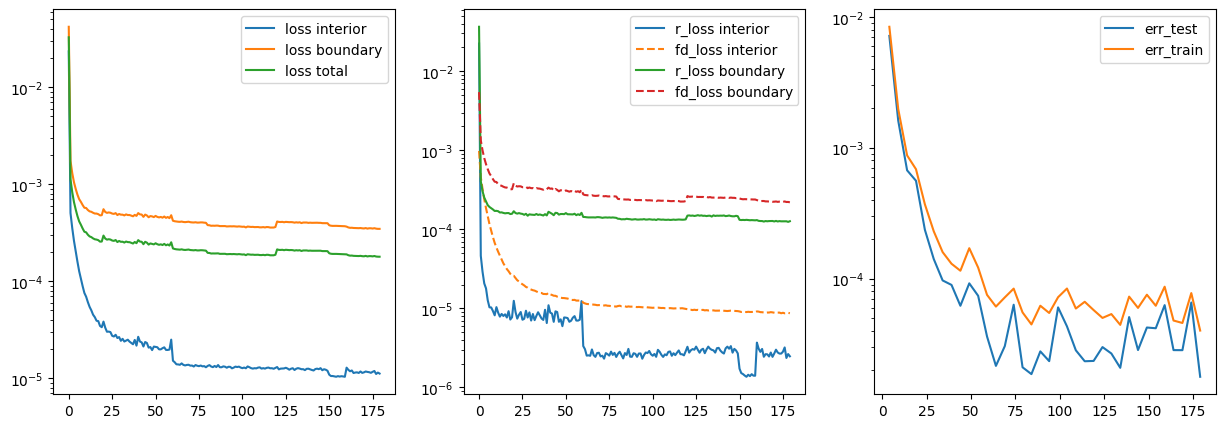

In [48]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(history['loss_i'],label='loss interior')
plt.plot(history['loss_b'],label='loss boundary')
plt.plot(history['loss'],label='loss total')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,2)
plt.plot(history['r_loss_i'],label='r_loss interior')
plt.plot(np.array(history['fd_l_loss_i'])*hyperParams['fd_l_weight'],'--',label='fd_loss interior')
plt.plot(history['r_loss_b'],label='r_loss boundary')
plt.plot(np.array(history['fd_l_loss_b'])*hyperParams['fd_l_weight'],'--',label='fd_loss boundary')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,3)
plt.plot(history['err_epoch'],history['err_test'],label='err_test')
plt.plot(history['err_epoch'],history['err_train'],label='err_train')
plt.legend()
plt.gca().set_yscale('log')

In [11]:
data[0].keys()

dict_keys(['nodes', 'elements', 'boundaryNodes', 'internalNodes', 'points', 'alpha', 'l', 'interp', 'interpD', 'interpB', 'normal', 'interpNormal', 'interpNodesB', 'dsdalpha'])

In [22]:
# for i in range(10):
#     data_i = data[i+10]
#     nodes = data_i['nodes']
#     elements = data_i['elements']
#     u = data_i['l']
#     PlotFEMsolution(nodes, elements,u)

In [5]:
def EncodeData(data,encoder,encoderB, nodesIE, s_alphaBE):
    nodes = data['nodes']
    boundaryNodes = data['boundaryNodes']
    internalNodes = data['internalNodes']
    nodesI = nodes[internalNodes]
    alpha = data['alpha']
    dsdalpha = data['dsdalpha']
    interp = data['interp']
    interpB = data['interpB']
    interpNormal = data['interpNormal']

    alpha_BE = alpha.reshape(-1,1) + s_alphaBE/dsdalpha
    alpha_BE = alpha_BE%1

    u_BE = interpB(alpha_BE)
    normal_BE = interpNormal(alpha_BE)

    lB = encoderB([u_BE,normal_BE])

    nodesI_IE = GetEncoderInputTP(nodesI,nodesIE)
    uI_IE = interp(nodesI_IE)
    bI_IE= np.isnan(uI_IE).astype(np.float64)
    uI_IE[np.isnan(uI_IE)] = 0

    lI = encoder([uI_IE,bI_IE])

    l = np.zeros((nodes.shape[0],lI.shape[-1]))
    l[internalNodes] = lI
    l[boundaryNodes] = lB
    return l

def PlotField(ax,fig, nodes, elements, vals):
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    triang = ax.tricontourf(triangulation, vals,10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.colorbar()
    fig.colorbar(triang, ax=ax, orientation='vertical', pad=0.1)
    ax.set_aspect('equal', adjustable='box')
    return

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    n_rows = np.ceil(r/3).astype(int)
    n_cols = min(r,3)
    plt.figure(figsize=(5*n_cols,4*n_rows),dpi=300)
    for i in range(r):
        plt.subplot(n_rows,n_cols,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        # plt.scatter(nodes[:,0],nodes[:,1],s=100,c=l[:,i])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

idx_data = 11

u_model,l_model = SINNsPredict(data[idx_data],encoderB,decoder,P,r,s_alphaBE)
l_enc = EncodeData(data[idx_data],encoder,encoderB, nodesIE, s_alphaBE)
u = data[idx_data]['l']
nodes = data[idx_data]['nodes']
elements = data[idx_data]['elements']

# fig,axs = plt.subplots(1,3,figsize=(15,3))
# PlotField(axs[0],fig, nodes, elements, u[:,0])
# PlotField(axs[1],fig, nodes, elements, u_model[:,0])
# PlotField(axs[2],fig, nodes, elements, np.abs(u_model[:,0]-u[:,0]))
# fig.show()


PlotFEMsolution(nodes, elements,u_model)
PlotFEMsolution(nodes, elements,u)
PlotFEMsolution(nodes, elements,np.abs(u_model-u))

PlotFEMsolution(nodes, elements,l_model)
PlotFEMsolution(nodes, elements,l_enc)
PlotFEMsolution(nodes, elements,l_model-l_enc)

# ms = 20
# alpha_val = 1
# plt.figure(figsize=(15,4))
# plt.subplot(1,3,1)
# plt.scatter(nodes[:,0],nodes[:,1],c=u[:,0],s=ms,alpha=alpha_val)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar()
# plt.subplot(1,3,2)
# plt.scatter(nodes[:,0],nodes[:,1],c=u_model[:,0],s=ms,alpha=alpha_val)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar()
# plt.subplot(1,3,3)
# plt.scatter(nodes[:,0],nodes[:,1],c=np.abs(u[:,0]-u_model[:,0]),s=ms,alpha=alpha_val)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar()
# plt.show()

# r = l_enc.shape[-1]
# plt.figure(figsize=(15,4*l_enc.shape[-1]))
# for i in range(r):
#     plt.subplot(r,3,3*i+1)
#     plt.scatter(nodes[:,0],nodes[:,1],c=l_enc[:,i],s=ms,alpha=alpha_val)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.colorbar()
#     plt.subplot(r,3,3*i+2)
#     plt.scatter(nodes[:,0],nodes[:,1],c=l_model[:,i],s=ms,alpha=alpha_val)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.colorbar()
#     plt.subplot(r,3,3*i+3)
#     plt.scatter(nodes[:,0],nodes[:,1],c=np.abs(l_enc[:,i]-l_model[:,i]),s=ms,alpha=alpha_val)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.colorbar()
# plt.show()

NameError: name 'encoderB' is not defined

In [ ]:
A = GetA(P)
A

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.99595034, 0.00225242],
       [0.00225242, 1.0065174 ]], dtype=float32)>

In [ ]:
A = GetA(P)
A

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2.0368083 , 0.02398216],
       [0.02398216, 2.0674067 ]], dtype=float32)>

1/1 [==============================] - 0s 10ms/step


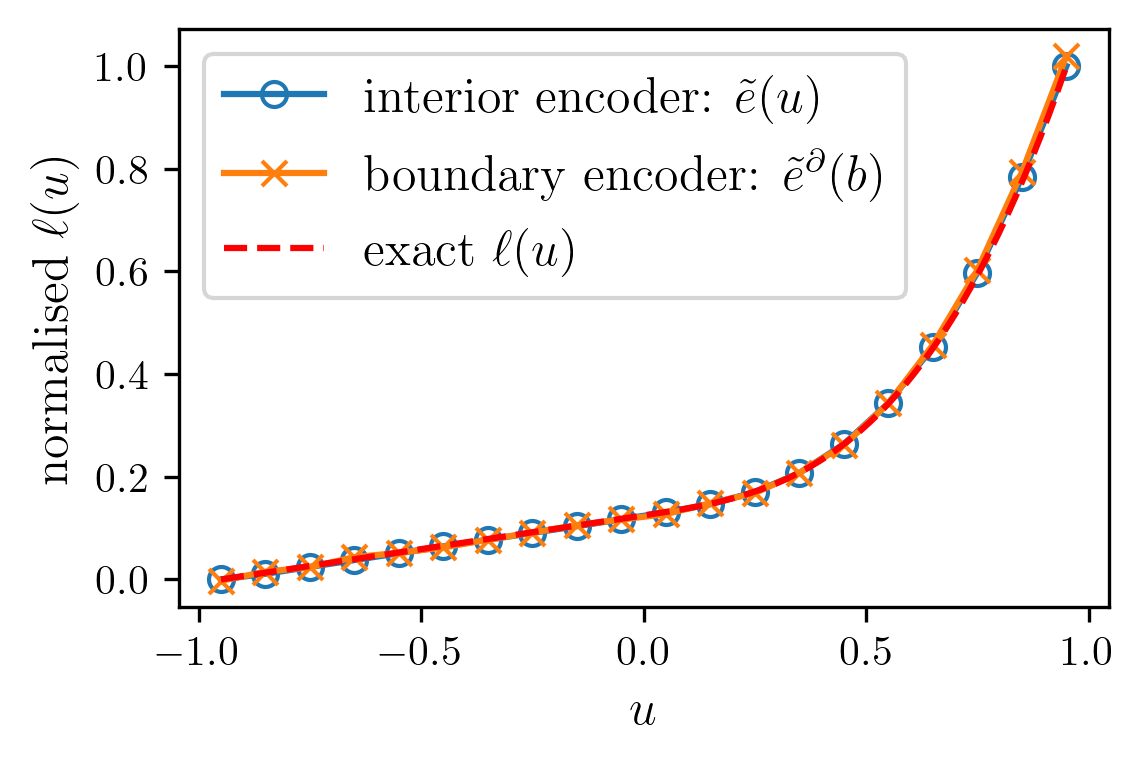

4/4 [==============================] - 0s 920us/step


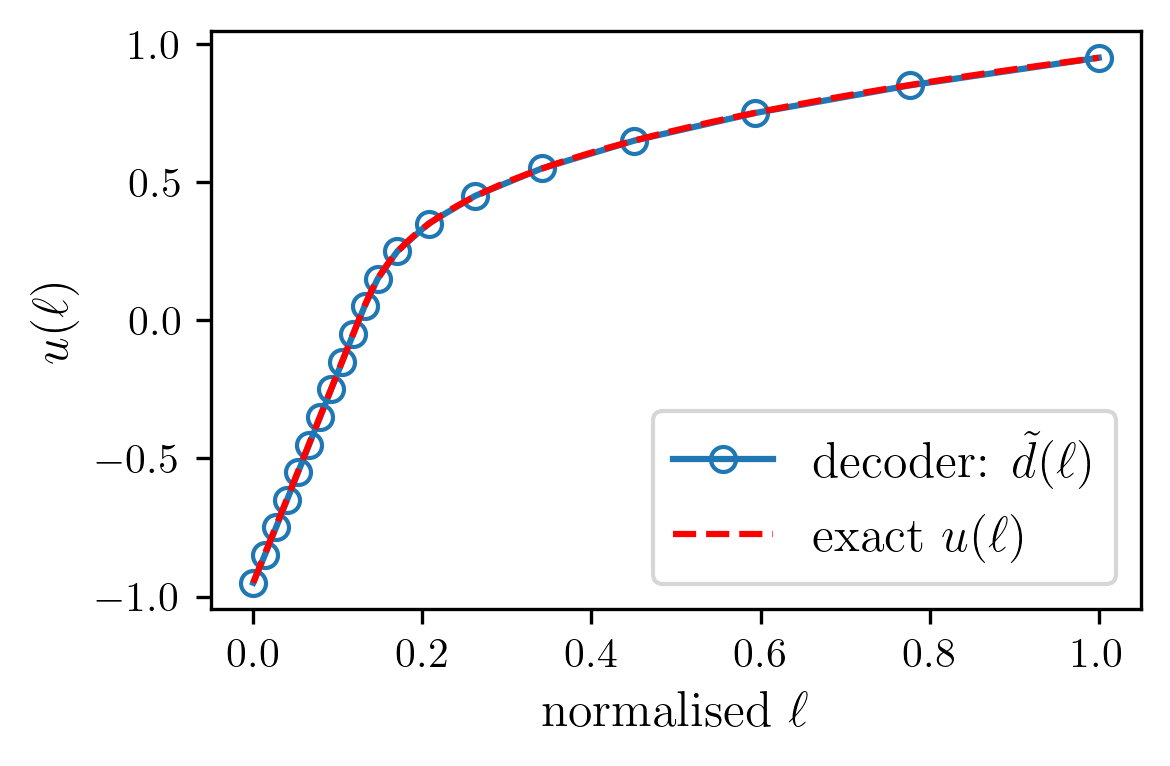

In [56]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

dpi=300
n_l = 20
u = np.linspace(-0.95,0.95,n_l)
# u = np.linspace(-1,1,100)
l_enc = encoder.predict([u.reshape(-1,1,1),np.zeros((n_l,1,1))])
# print(l_enc)
normals = np.zeros((n_l,1,2))
normals[:,0,0] = 1
l_encB = encoderB.predict([u.reshape(-1,1),normals])
l_encB = (l_encB-l_enc.min())/(l_enc.max()-l_enc.min())
l_enc = (l_enc-l_enc.min())/(l_enc.max()-l_enc.min())
u_exact = np.linspace(-0.95,0.95,100)
l_exact = np.zeros(100)
l_exact[:50] = u_exact[u_exact<=0]/2
l_exact[50:] = u_exact[u_exact>0]**3*10/3+u_exact[u_exact>0]/2
# l_exact = -l_exact
l_exact = (l_exact-l_exact.min())/(l_exact.max()-l_exact.min())
fig, ax = plt.subplots(figsize=(4,2.5), dpi=dpi)
plt.plot(u,l_enc,'-o',markerfacecolor='none')
plt.plot(u,l_encB,'-x')
plt.plot(u_exact,l_exact,'--r')
plt.legend(['interior encoder: $\\tilde{e}(u)$','boundary encoder: $\\tilde{e}^{\partial}(b)$','exact $\ell(u)$'],fontsize=12)
plt.ylabel('normalised $\ell(u)$',fontsize=12)
plt.xlabel('$u$',fontsize=12)
plt.show()

l = np.linspace(0,0.4,100)
u_decoder = decoder.predict(l.reshape(-1,1))
l_dec = np.interp(u,u_decoder.flatten()[::],l[::])
# l_dec = np.interp(u,u_decoder.flatten()[::],l[::])
l_dec = (l_dec-l_dec.min())/(l_dec.max()-l_dec.min())
fig, ax = plt.subplots(figsize=(4,2.5), dpi=dpi)
plt.plot(l_dec,u,'-o',markerfacecolor='none')
# plt.gca().twiny()
plt.plot(l_exact,u_exact,'--r')
plt.legend(['decoder: $\\tilde{d}(\ell)$','exact $u(\ell)$'],loc='lower right',fontsize=12)
plt.xlabel('normalised $\ell$',fontsize=12)
plt.ylabel('$u(\ell)$',fontsize=12)
plt.show()

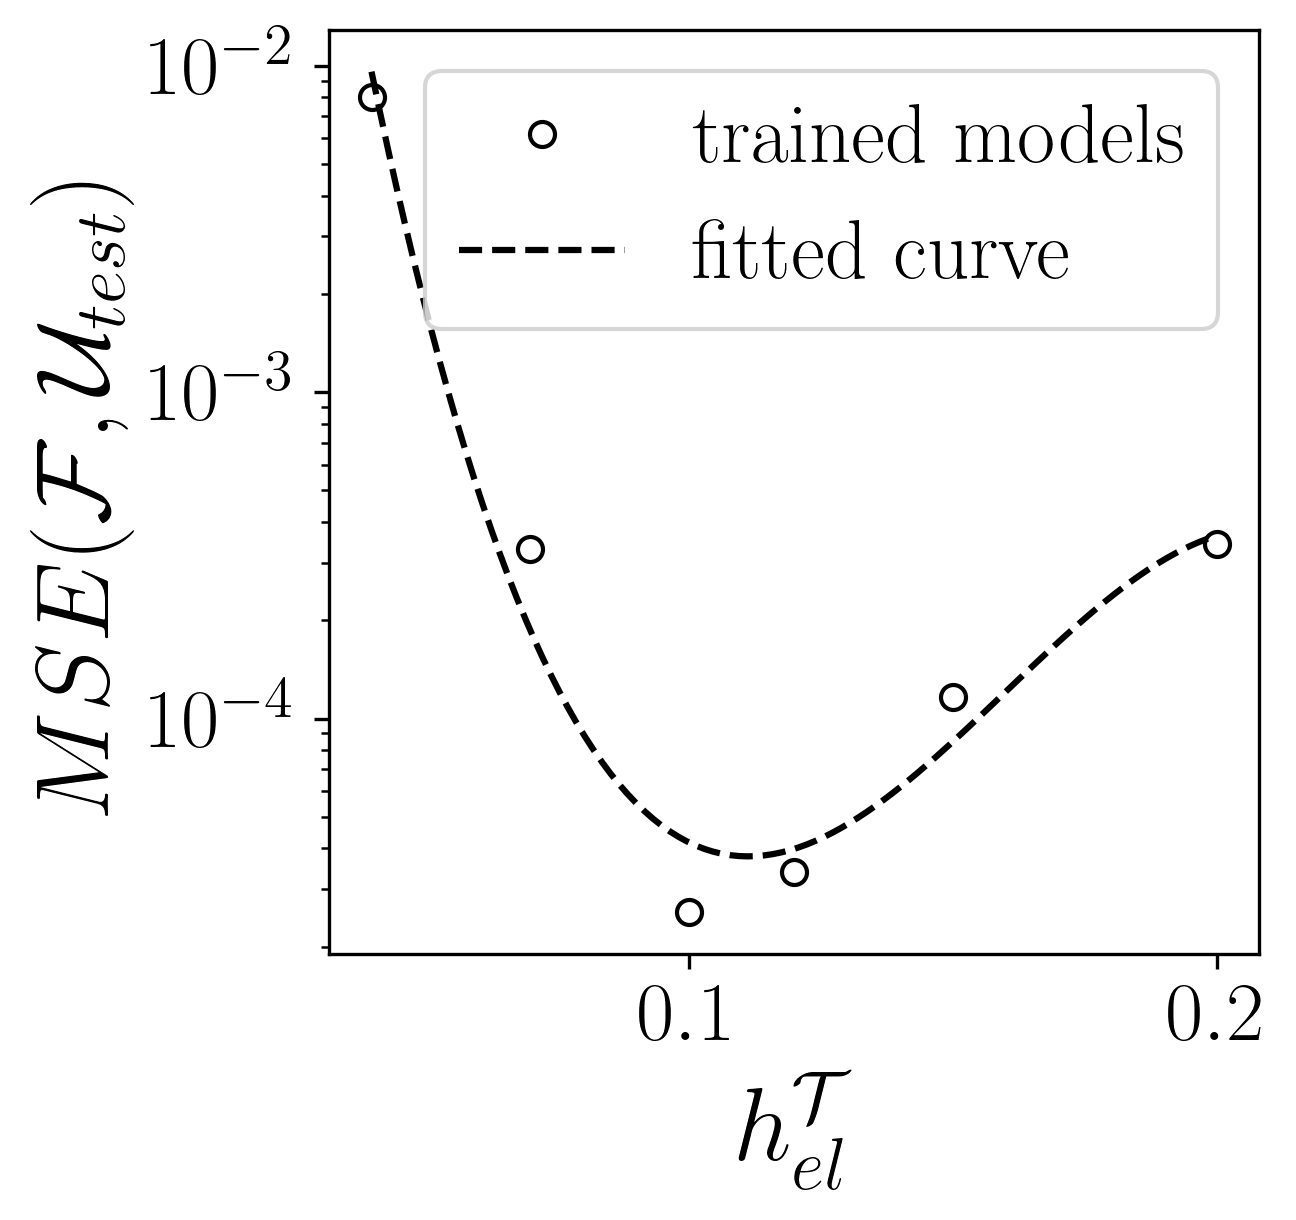

In [63]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

err_train_mean = [0.008045, 0.00033115,	2.56E-05,	3.39E-05,	0.000116769,	0.000341956]
err_train_std = [3.25E-05, 2.18E-05,	6.90E-06,	1.45E-05,	1.46E-05,	5.69E-05]
elSize = [0.04,	0.07,	0.1,	0.12,	0.15,	0.2]

p = np.polyfit(elSize,np.log(err_train_mean),3)
x = np.linspace(elSize[0],elSize[-1],100)
y = np.exp(np.polyval(p,x))

dpi=300
fig, ax = plt.subplots(figsize=(4,4), dpi=dpi)
plt.plot(elSize,err_train_mean,'ok', label='trained models', markerfacecolor='none')
plt.plot(x,y,'k',label='fitted curve',linestyle='--')
# plt.errorbar(elSize,err_train_mean,err_train_std,fmt='o')
plt.gca().set_yscale('log')

fontsize = 25
plt.xlabel('$h_{el}^{\mathcal{T}}$',fontsize=fontsize)
plt.ylabel('$MSE(\mathcal{F},\mathcal{U}_{test})$',fontsize=fontsize)
fontsize = 20
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=20)

Text(0, 0.5, '$\\eta(\\mathcal{F},\\mathcal{U}_{test}) \\; [\\%]$')

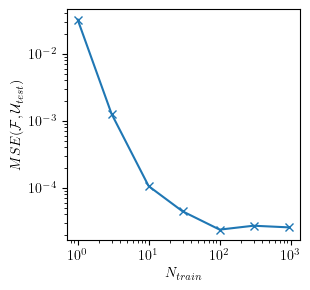

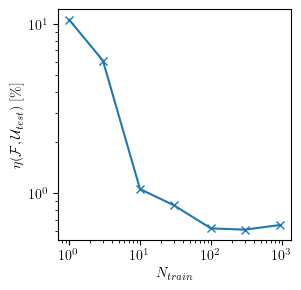

In [61]:
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

N_T = [1,	3,	10,	30,	100,	300,	950]
err = [0.0324,	0.00127,	0.0001057,	4.45E-05,	2.37E-05,	2.71E-05,	2.56E-05]
eta = [10.65,	6.10,	1.06,	0.85,	0.62,	0.61,	0.65]

# p = np.polyfit(np.log(N_T),np.log(err),1)
# x = np.linspace(N_T[0],N_T[-1],1000)
# y = np.exp(np.polyval(p,np.log(x)))

plt.figure(figsize=(3,3),dpi=100)

plt.plot(N_T,err,'-x', label='trained models', markerfacecolor='none')
# plt.plot(x,y)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('$N_{train}$')
plt.ylabel('$MSE(\mathcal{F},\mathcal{U}_{test})$')

plt.figure(figsize=(3,3),dpi=100)
plt.plot(N_T,eta,'-x', label='trained models', markerfacecolor='none')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('$N_{train}$')
plt.ylabel('$\eta(\mathcal{F},\mathcal{U}_{test}) \; [\%]$')
